# Model Training

This notebook contains code for training the KNN and NN models, along with making some final predictions (recomendations) on a validation set of users.

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm # For progress bars - https://deepnote.com/blog/ultimate-guide-to-tqdm-library-in-python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

np.random.seed(42)

# Baseline Predictions

Before training the KNN or the NN models, let's create a baseline for predictions. We will be using the Topic field to make recommendations in the end, so let's use the most common topic for each industry and segment to make predictions and validate the accuracy.

In [ ]:
# Read in interactions data
interactions_df = pd.read_csv('data/processed/interactions_agg_long.csv')

# Split into train and test
train_baseline, test_baseline = train_test_split(interactions_df, test_size=0.2, random_state=42)

# Find most popular Topic for each Industry & Segment combo - NOTICE: Claude helped me create this consolidated line of code. My original lines were broken out, Claude consolidated for me.
most_popular_topics = (train_baseline.groupby(['INDUSTRY', 'SEGMENT', 'TOPIC'])
                       .size()
                       .reset_index(name='count')
                       .sort_values('count', ascending=False)
                       .groupby(['INDUSTRY', 'SEGMENT'])
                       .first()
                       .reset_index())

# NOTICE: Claude created the following code. I was struggling to figure out how to execute this in Python. I wrote up some sudo SQL and had Claude translate to Python. 
# Calculate 'Training' Accuracy
train_with_popular = train_baseline.merge(
    most_popular_topics[['INDUSTRY', 'SEGMENT', 'TOPIC']], 
    on=['INDUSTRY', 'SEGMENT'],
    suffixes=('_actual', '_popular')
)
train_baseline_accuracy = (train_with_popular['TOPIC_actual'] == train_with_popular['TOPIC_popular']).mean() * 100

# NOTICE: Claude created the following code. I was struggling to figure out how to execute this in Python. I wrote up some sudo SQL and had Claude translate to Python. 
# Calculate 'Test' Accuracy  
test_with_predictions = test_baseline.merge(
    most_popular_topics[['INDUSTRY', 'SEGMENT', 'TOPIC']], 
    on=['INDUSTRY', 'SEGMENT'],
    how='left',
    suffixes=('_actual', '_predicted')
)
test_with_predictions['TOPIC_predicted'].fillna('None', inplace=True)
test_baseline_accuracy = (test_with_predictions['TOPIC_actual'] == test_with_predictions['TOPIC_predicted']).mean() * 100

# Print Metrics
print(f"Training Accuracy: {train_baseline_accuracy:.2f}%")
print(f"Test Accuracy: {test_baseline_accuracy:.2f}%")

Training set: 3,935,356 interactions
Test set: 983,839 interactions


For each Industry and Segment combination, if we recomend only the most popular Topic for each, we will score around 23% accuracy. This will be considered our 'baseline' to beat.

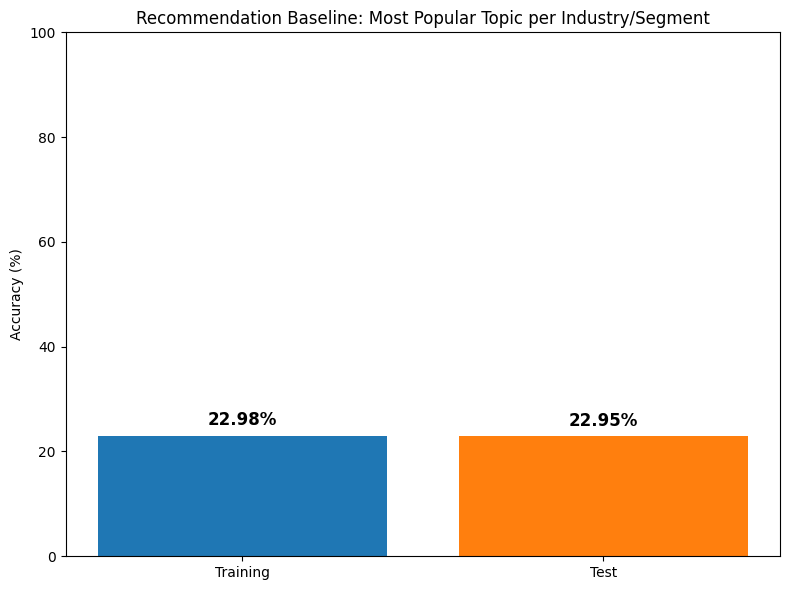

In [113]:
# Visualize Results
fig, ax = plt.subplots(figsize=(8, 6))

accuracies = [train_baseline_accuracy, test_baseline_accuracy]
labels = ['Training', 'Test']
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(labels, accuracies, color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Recommendation Baseline: Most Popular Topic per Industry/Segment')
ax.set_ylim(0, 100)

for i, acc in enumerate(accuracies):
    ax.text(i, acc + 2, f'{acc:.2f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()



# KNN

Precision measures the accuracy of positive predictions, indicating what fraction of the items the model predicted as positive were actually correct. 

Recall, also known as sensitivity, measures the model's ability to find all the relevant instances, indicating what fraction of all the actual positive items were correctly identified

F1-score is a metric used to evaluate the performance of a binary classification model by combining precision and recall into a single value. It is the harmonic mean of precision and recall, with a perfect score of 1 and the worst at 0. The F-score is particularly useful for imbalanced datasets where accuracy can be misleading.

In [78]:
# Read in data
knn_dataset = pd.read_csv('data/processed/knn_dataset.csv', sep=',')

#knn_dataset = knn_dataset.head(42000)

# Split to Train and Test
train_knn, test_knn = train_test_split(knn_dataset, test_size=0.2, random_state=42)
print(f"Training set: {len(train_knn)} users")
print(f"Test set: {len(test_knn)} users")

Training set: 139002 users
Test set: 34751 users


In [181]:
# Get industry and segment distributions for KNN train/test sets
knn_train_industry = train_knn['INDUSTRY'].value_counts().sort_index()
knn_test_industry = test_knn['INDUSTRY'].value_counts().sort_index()

knn_train_segment = train_knn['SEGMENT'].value_counts().sort_index()
knn_test_segment = test_knn['SEGMENT'].value_counts().sort_index()

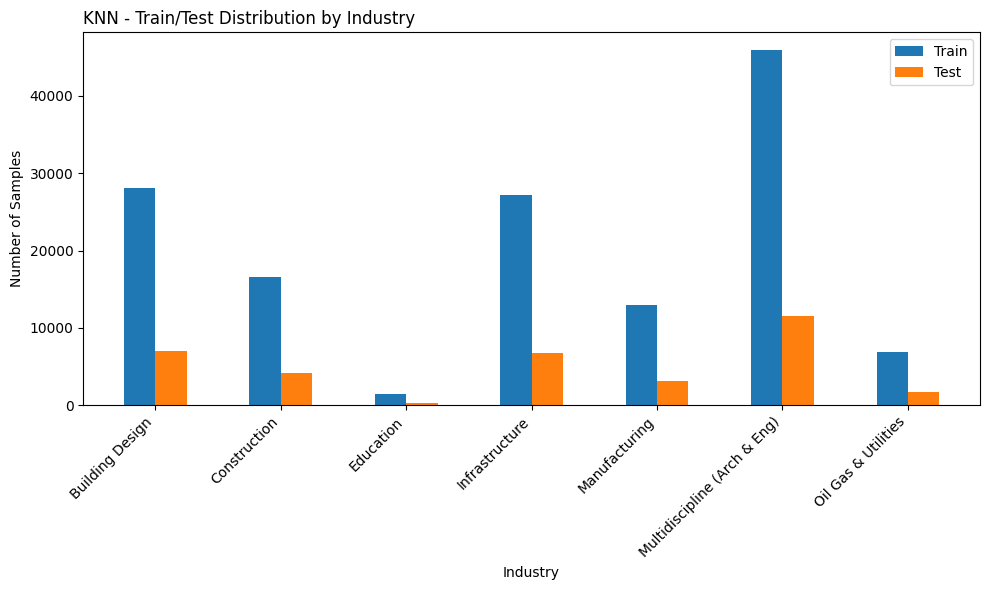

In [198]:
fig, ax = plt.subplots(figsize=(10, 6))

# Offset Bar Chart
x = np.arange(len(knn_train_industry))
width = 0.25
bars1 = ax.bar(x - width/2, knn_train_industry.values, width, label='Train')
bars2 = ax.bar(x + width/2, knn_test_industry.values, width, label='Test')
ax.set_xlabel('Industry')
ax.set_ylabel('Number of Samples')
ax.set_title('KNN - Train/Test Distribution by Industry', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(knn_train_industry.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


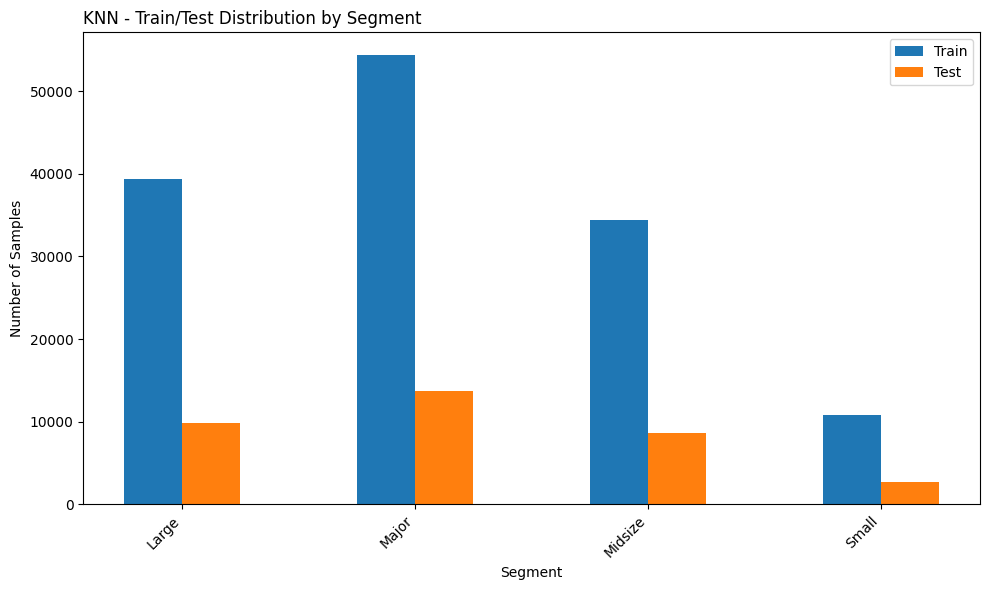

In [199]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set up bar positions
x = np.arange(len(knn_train_segment))
width = 0.25

# Offset Bar Chart
bars1 = ax.bar(x - width/2, knn_train_segment.values, width, label='Train')
bars2 = ax.bar(x + width/2, knn_test_segment.values, width, label='Test')
ax.set_xlabel('Segment')
ax.set_ylabel('Number of Samples')
ax.set_title('KNN - Train/Test Distribution by Segment', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(knn_train_segment.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

First we will train on a subset to get an idea of what value of k will be best.

In [139]:
# Subtset for testing
knn_dataset_sub = knn_dataset.head(10000)
train_knn_sub, test_knn_sub = train_test_split(knn_dataset_sub, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()

# Select Columns
exclude_cols = ['USER_ID', 'TENANT_ID', 'INDUSTRY',  'SEGMENT' ]
train_cols = [col for col in train_knn_sub.columns if col not in exclude_cols]

# Prepare Training
X_train = train_knn_sub[train_cols].values
X_train_scaled = scaler.fit_transform(X_train)

# Prepare Testing
X_test = test_knn_sub[train_cols].values
X_test_scaled = scaler.transform(X_test)



# Set k values to test
k_values = [3, 5, 10, 15, 20, 25, 30]
results = []

for k in k_values:
    print(f"\nTraining with k={k}")
    
    # Train model with k
    model_k = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    model_k.fit(X_train_scaled)
    
    # Prepare for metrics
    precisions = []
    recalls = []
    
    # Loop through each user
    for usr in range(len(X_test_scaled)):
        
        # Locate what user consumed
        actual_consumption = test_knn_sub.iloc[usr][train_cols].values
        
        # Grab Topics of what they consumed
        pos_vals = np.where(actual_consumption > 0) # Only grab what they consumed
        indices_array = pos_vals[0] # Just grab first val
        actual_consumed_indices = set(indices_array) # Convert to set for fast checking
        
        # Skip users who consumed nothing
        if len(actual_consumed_indices) == 0:
            continue
        
        # Find k most similar users, return distances and neighbor rows
        distances, neighbor_indices = model_k.kneighbors([X_test_scaled[usr]], n_neighbors=k)
        neighbor_indx = neighbor_indices[0]
        
        # Locate what neighbor consumed
        neighbor_original = train_knn_sub.iloc[neighbor_indx][train_cols].values
        
        # Calculate a weighted average of what similar users consumed
        similarities = 1 / (1 + distances[0]) # Closer users = higher similarity
        weights = similarities / similarities.sum() # Normalize to sum to 1
        predicted_scores = np.dot(weights, neighbor_original) # Each neighbor's consumption multiplied by their weight
        
        # Find k topics with the highest predicted scores
        sorted_indices = np.argsort(predicted_scores) # Sort the scores and get the indices (lowest to highest)
        top_k_sorted_indices = sorted_indices[-k:] # Take the last k items (the highest scores)
        top_k_reversed = top_k_sorted_indices[::-1] # Reverse the order (highest to lowest)
        top_k_indices = set(top_k_reversed) # Convert to a set

        # Check how many recommendations match what the user actually consumed
        if len(top_k_indices) > 0:
            overlapping_indices = actual_consumed_indices.intersection(top_k_indices) # Find which indices appear in BOTH sets
            hits = len(overlapping_indices) # Count how many overlaps were found
            
            precision = hits / len(top_k_indices)
            recall = hits / len(actual_consumed_indices)
            precisions.append(precision)
            recalls.append(recall)
    
    # Precision Average
    if precisions: 
        avg_precision = np.mean(precisions)
    else:
        avg_precision = 0

    # Recall Average
    if recalls:
        avg_recall = np.mean(recalls)
    else:
        avg_recall = 0

    # Calcaulte F1 score
    if avg_precision + avg_recall > 0:
        f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    else:
        f1 = 0
    
    # Store and print results for k
    results.append({'k': k, 'Precision': avg_precision, 'Recall': avg_recall, 'F1': f1})
    print(f"  k={k}: P={avg_precision:.4f}, R={avg_recall:.4f}, F1={f1:.4f}")

# Show final results
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['F1'].idxmax(), 'k']
print(f"\nBest k: {int(best_k)}")


Training with k=3
  k=3: P=0.8777, R=0.6980, F1=0.7776

Training with k=5
  k=5: P=0.6699, R=0.8136, F1=0.7348

Training with k=10
  k=10: P=0.4020, R=0.8956, F1=0.5550

Training with k=15
  k=15: P=0.2838, R=0.9216, F1=0.4340

Training with k=20
  k=20: P=0.2208, R=0.9390, F1=0.3575

Training with k=25
  k=25: P=0.1813, R=0.9506, F1=0.3045

Training with k=30
  k=30: P=0.1540, R=0.9591, F1=0.2654

Best k: 3


K = 3 appears to be best overall, so I will train on the full data set using this.

In [ ]:
# Set Model
k_val = 3
model = NearestNeighbors(n_neighbors=k_val, metric='cosine', algorithm='brute')

# Standardize
scaler = StandardScaler()

# Select Columns
exclude_cols = ['USER_ID', 'TENANT_ID', 'INDUSTRY',  'SEGMENT' ]
train_cols = [col for col in train_knn.columns if col not in exclude_cols]

# Prepare Train sets
X_train = train_knn[train_cols].values
X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled)

# Prepare Test sets
X_test = test_knn[train_cols].values
X_test_scaled = scaler.transform(X_test)

# Prepare for metrics
precisions = []
recalls = []

# Loop through each user
for usr in tqdm(range(len(X_test_scaled)), desc="Evaluating"):
    
    # Locate what user consumed
    actual_consumption = test_knn.iloc[usr][train_cols].values

    # Grab Topics of what they consumed
    pos_vals = np.where(actual_consumption > 0) # Only grab what they consumed
    indices_array = pos_vals[0] # Just grab first val
    actual_consumed_indices = set(indices_array) # Convert to set for fast checking
    
    # Skip users who consumed nothing
    if len(actual_consumed_indices) == 0:
        continue
    
    # Find k most similar users, return distances and neighbor rows
    distances, neighbor_indices = model.kneighbors([X_test_scaled[usr]], n_neighbors=k_val)
    neighbor_indx = neighbor_indices[0]
    
    # Locate what neighbor consumed
    neighbor_original = train_knn.iloc[neighbor_indx][train_cols].values
    
    # Calculate a weighted average of what similar users consumed
    similarities = 1 / (1 + distances[0]) # Closer users = higher similarity
    weights = similarities / similarities.sum() # Normalize to sum to 1
    predicted_scores = np.dot(weights, neighbor_original) # Each neighbor's consumption multiplied by their weight
    
    # Find k topics with the highest predicted scores
    sorted_indices = np.argsort(predicted_scores) # Sort the scores and get the indices (lowest to highest)
    top_k_sorted_indices = sorted_indices[-k_val:] # Take the last k items (the highest scores)
    top_k_reversed = top_k_sorted_indices[::-1] # Reverse the order (highest to lowest)
    top_k_indices = set(top_k_reversed) # Convert to a set
    
    # Check how many recommendations match what the user actually consumed
    if len(top_k_indices) > 0:
        overlapping_indices = actual_consumed_indices.intersection(top_k_indices) # Find which indices appear in BOTH sets
        hits = len(overlapping_indices) # Count how many overlaps were found
        
        precision = hits / len(top_k_indices)
        recall = hits / len(actual_consumed_indices)
        precisions.append(precision)
        recalls.append(recall)

# Precision Average
if precisions: 
    avg_precision = np.mean(precisions)
else:
    avg_precision = 0

# Recall Average
if recalls:
    avg_recall = np.mean(recalls)
else:
    avg_recall = 0

# Calcaulte F1 score
if avg_precision + avg_recall > 0:
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
else:
    f1 = 0


# Show final results
print(f"Users evaluated: {len(precisions)}")
print(f"Precision@{k_val}: {avg_precision:.4f} ({avg_precision:.1%})")
print(f"Recall@{k_val}: {avg_recall:.4f} ({avg_recall:.1%})")
print(f"F1@{k_val}: {f1:.4f} ({f1:.1%})")

# Save model for later predictions
knn_model_final = model



Evaluating: 100%|██████████| 34751/34751 [24:52<00:00, 23.29it/s]

Users evaluated:  34751
Precision@3:     0.9110 (91.1%)
Recall@3:        0.7242 (72.4%)
F1@3:            0.8069 (80.7%)

Interpretation:
  - Model can correctly predict 91.1% of top-3 recommendations
  - Model can recall 72.4% of what users actually consumed


Interpretation:
  - Model can correctly predict 91% of top-3 recommendations
  - Model can recall 72% of what users actually consumed

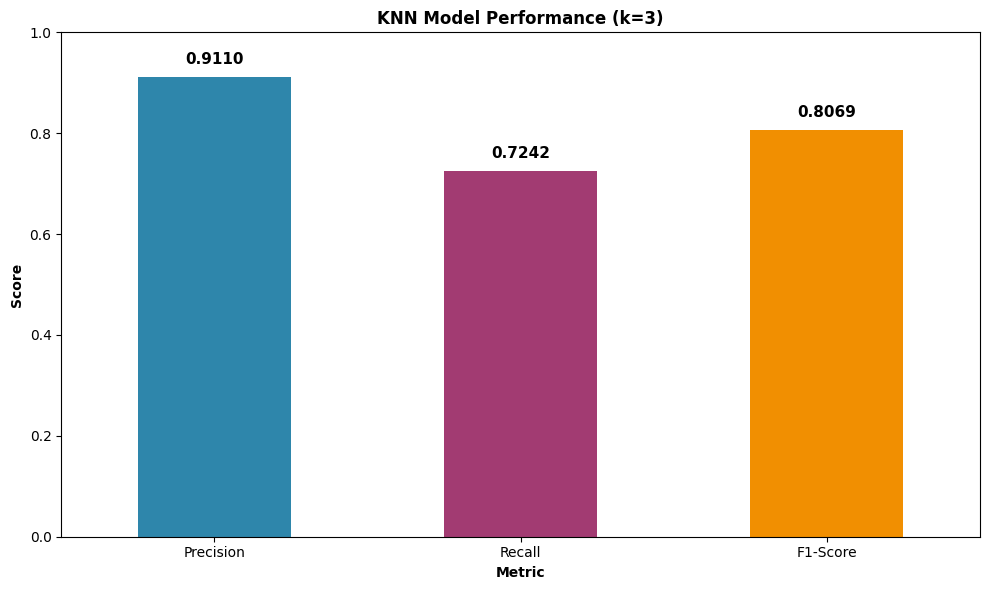

In [ ]:
# Create bar chart using knn metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Store metrics
knn_data = pd.Series({
    'Precision': avg_precision,
    'Recall': avg_recall,
    'F1-Score': f1
})

knn_data.plot(kind='bar', ax=ax, color=['#2E86AB', '#A23B72', '#F18F01'])

# Add value labels on bars
for i, (metric, value) in enumerate(knn_data.items()):
    ax.text(i, value + 0.02, f'{value:.4f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Metric', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title(f'KNN Model Performance (k={k_val})', fontweight='bold')
ax.set_ylim(0, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Neural Network



In [99]:
# Read in data
nn_dataset = pd.read_csv('data/processed/neural_network_dataset.csv', sep=',')

# Read in grouped Topics
unique_topics_grouped = pd.read_csv('data/processed/unique_topics_grouped.csv', sep=',')

# Left Join new grouped Topics
nn_dataset = nn_dataset.merge(
    unique_topics_grouped, 
    left_on='target_topic_eng',
    right_on='TOPIC', 
    how='left'
)

# Rename CATEGORY and drop TOPIC
nn_dataset = nn_dataset.rename(columns={'CATEGORY': 'target_category_eng'})
nn_dataset = nn_dataset.drop(columns=['TOPIC'])

# Encode target_category_eng to create target_category
category_encoder = LabelEncoder()
nn_dataset['target_category'] = category_encoder.fit_transform(nn_dataset['target_category_eng'])

#nn_dataset = nn_dataset.head(1000000)




In [100]:
# Count distinct values in target columns
print("Topic Subtopic distinct values:", nn_dataset['target_topic_subtopic'].nunique())
print("Topic distinct values:", nn_dataset['target_topic'].nunique())
print("Category distinct values:", nn_dataset['target_category'].nunique())


Topic Subtopic distinct values: 577
Topic distinct values: 206
Category distinct values: 30


In [101]:
# Select X Columns
feature_columns = ['topic_subtopic_1', 'topic_subtopic_2', 'topic_subtopic_3', 'topic_subtopic_4', 'topic_subtopic_5']

X_vals = nn_dataset[feature_columns].values
y_vals = nn_dataset['target_topic'].values
user_ids = nn_dataset['user_id'].values  # Get user IDs for grouping

# Split by user_id to prevent data leakage: https://www.geeksforgeeks.org/machine-learning/how-to-generate-a-train-test-split-based-on-a-group-id/
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X_vals, y_vals, groups=user_ids):
    X_train = X_vals[train_idx]
    X_test = X_vals[test_idx]
    y_train = y_vals[train_idx]
    y_test = y_vals[test_idx]

print(f"Training set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")
print(f"Number of classes: {len(np.unique(y_vals))}")

Training set: 3388851 rows
Test set: 862071 rows
Number of classes: 206


In [102]:
# Source: https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Create a custom PyTorch Dataset
class NNDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Datasets
train_dataset = NNDataset(X_train, y_train)
test_dataset = NNDataset(X_test, y_test)

# Data Loaders
batch_size = 4096 # 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [204]:
# Recreate the split to get indices
train_indices = []
test_indices = []
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X_vals, y_vals, groups=user_ids):
    train_indices = train_idx
    test_indices = test_idx

# Get the full dataset with industry/segment info (encoded)
nn_train_data = nn_dataset.iloc[train_indices]
nn_test_data = nn_dataset.iloc[test_indices]

# Get distributions of encoded vals
nn_train_industry_encoded = nn_train_data['industry'].value_counts().sort_index()
nn_test_industry_encoded = nn_test_data['industry'].value_counts().sort_index()

nn_train_segment_encoded = nn_train_data['segment'].value_counts().sort_index()
nn_test_segment_encoded = nn_test_data['segment'].value_counts().sort_index()

# Grab encoding files
industry_enc = pd.read_csv('data/processed/industry_enc.csv')
segment_enc = pd.read_csv('data/processed/segment_enc.csv')

# Map encoded values back to actual names
nn_train_industry = nn_train_industry_encoded.copy()
nn_train_industry.index = nn_train_industry.index.map(industry_enc.set_index('INDUSTRY_encoded')['INDUSTRY'].to_dict())

nn_test_industry = nn_test_industry_encoded.copy()
nn_test_industry.index = nn_test_industry.index.map(industry_enc.set_index('INDUSTRY_encoded')['INDUSTRY'].to_dict())

nn_train_segment = nn_train_segment_encoded.copy()
nn_train_segment.index = nn_train_segment.index.map(segment_enc.set_index('SEGMENT_encoded')['SEGMENT'].to_dict())

nn_test_segment = nn_test_segment_encoded.copy()
nn_test_segment.index = nn_test_segment.index.map(segment_enc.set_index('SEGMENT_encoded')['SEGMENT'].to_dict())

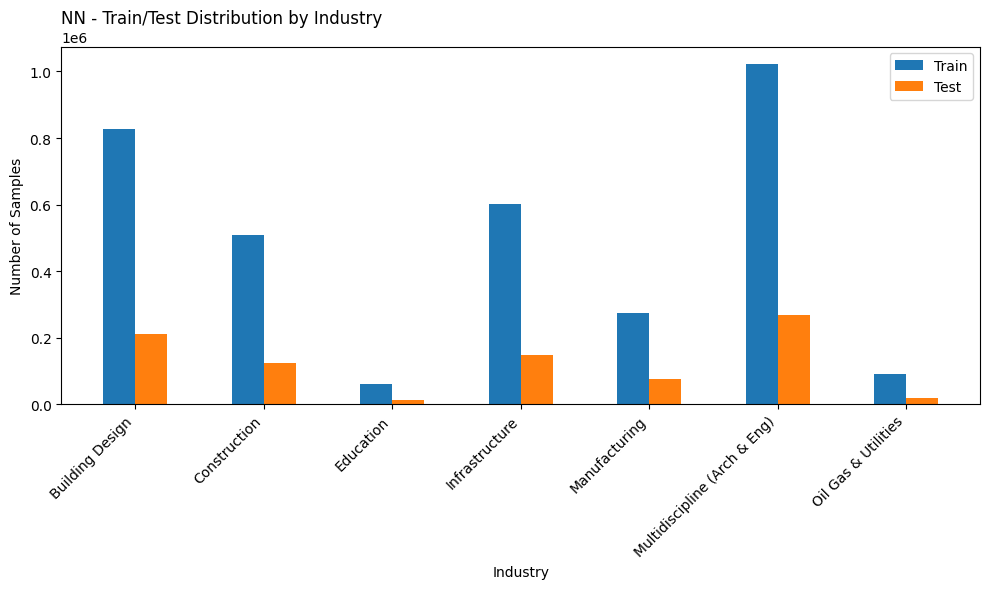

In [205]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set up bar positions
x = np.arange(len(nn_train_industry))
width = 0.25

# Offset Bar Chart
bars1 = ax.bar(x - width/2, nn_train_industry.values, width, label='Train')
bars2 = ax.bar(x + width/2, nn_test_industry.values, width, label='Test')
ax.set_xlabel('Industry')  # Changed from 'Industry (Encoded)'
ax.set_ylabel('Number of Samples')
ax.set_title('NN - Train/Test Distribution by Industry', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(nn_train_industry.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

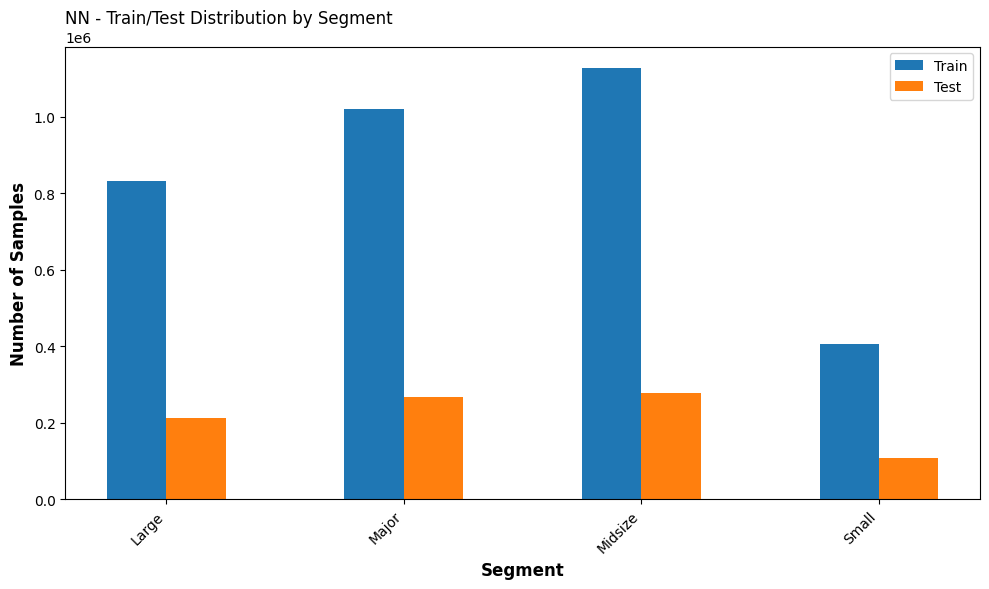

In [206]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set up bar positions
x = np.arange(len(nn_train_segment))
width = 0.25

# Offset Bar Chart
bars1 = ax.bar(x - width/2, nn_train_segment.values, width, label='Train')
bars2 = ax.bar(x + width/2, nn_test_segment.values, width, label='Test')
ax.set_xlabel('Segment', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
ax.set_title('NN - Train/Test Distribution by Segment', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(nn_train_segment.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [103]:
# Get Device: https://docs.pytorch.org/docs/stable/notes/mps.html
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


After trying a handful of different model complexities, a deep and wide model with batch norm proved most powerful.

In [104]:
# Define the Neural Network architecture
# class ContentRecommenderNN(nn.Module):
#     def __init__(self):
#         super(ContentRecommenderNN, self).__init__()
        
#         # Simple feedforward architecture
#         self.fc1 = nn.Linear(5, 128)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(128, 64)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(64, 206)
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         return x


# class ContentRecommenderNN(nn.Module):
#     def __init__(self):
#         super(ContentRecommenderNN, self).__init__()
        
#         # Go deeper: 5 hidden layers instead of 3
#         self.fc1 = nn.Linear(5, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.relu1 = nn.ReLU()
        
#         self.fc2 = nn.Linear(256, 256)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(256, 256)  # Additional layer
#         self.bn3 = nn.BatchNorm1d(256)
#         self.relu3 = nn.ReLU()
        
#         self.fc4 = nn.Linear(256, 128)
#         self.bn4 = nn.BatchNorm1d(128)
#         self.relu4 = nn.ReLU()
        
#         self.fc5 = nn.Linear(128, 128)  # Additional layer
#         self.bn5 = nn.BatchNorm1d(128)
#         self.relu5 = nn.ReLU()
        
#         self.fc6 = nn.Linear(128, 206)
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
        
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
        
#         x = self.fc3(x)
#         x = self.bn3(x)
#         x = self.relu3(x)
        
#         x = self.fc4(x)
#         x = self.bn4(x)
#         x = self.relu4(x)
        
#         x = self.fc5(x)
#         x = self.bn5(x)
#         x = self.relu5(x)
        
#         x = self.fc6(x)
#         return x


class ContentRecommenderNN(nn.Module):
    def __init__(self):
        super(ContentRecommenderNN, self).__init__()
        
        self.fc1 = nn.Linear(5, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(128, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()
        
        self.fc6 = nn.Linear(128, 206)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        x = self.fc6(x)
        return x

model = ContentRecommenderNN().to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

ContentRecommenderNN(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=128, out_features=206, bias=True)
)

Total parameters: 211,150


In [105]:
# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


In [106]:
# Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop
# This was not covered in detail in DS 776, I had to rely heavily on PyTroch documentation and some AI use

# Training function
def train_epoch(model, train_loader, loss_func, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for features, labels in pbar:
        features, labels = features.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Make predictions for this batch - Forward pass
        outputs = model(features)

        # Compute the loss and its gradients
        loss = loss_func(outputs, labels)
        loss.backward()

        optimizer.step()
        
        # Statistics - Disclaimer: Claude assisted me with this part
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with current metrics
        current_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


In [107]:
# Evaluation function
def evaluate(model, test_loader, loss_func, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(test_loader, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for features, labels in pbar:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)

            loss = loss_func(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            current_acc = 100 * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [ ]:
# Training loop with epoch progress bar
num_epochs = 50
# Training on 40 produced: 40/40 [24:06<00:00, 36.17s/it, train_loss=1.9841, train_acc=46.04%, test_loss=2.0252, test_acc=45.74%]

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


# Add progress bar for epochs
epoch_pbar = tqdm(range(num_epochs), desc='Overall Progress')

for epoch in epoch_pbar:
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, loss_func, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, loss_func, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Update epoch progress bar with current metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.2f}%',
        'test_loss': f'{test_loss:.4f}',
        'test_acc': f'{test_acc:.2f}%',
    })
    

Overall Progress: 100%|██████████| 50/50 [25:32<00:00, 30.65s/it, train_loss=1.2482, train_acc=63.76%, test_loss=1.2553, test_acc=63.98%]


After 50 epochs, the model can accurately predict the next consumed Topic 64% of the time. The model does well to not overfit as the train and test metrics are very close together every epoch. 

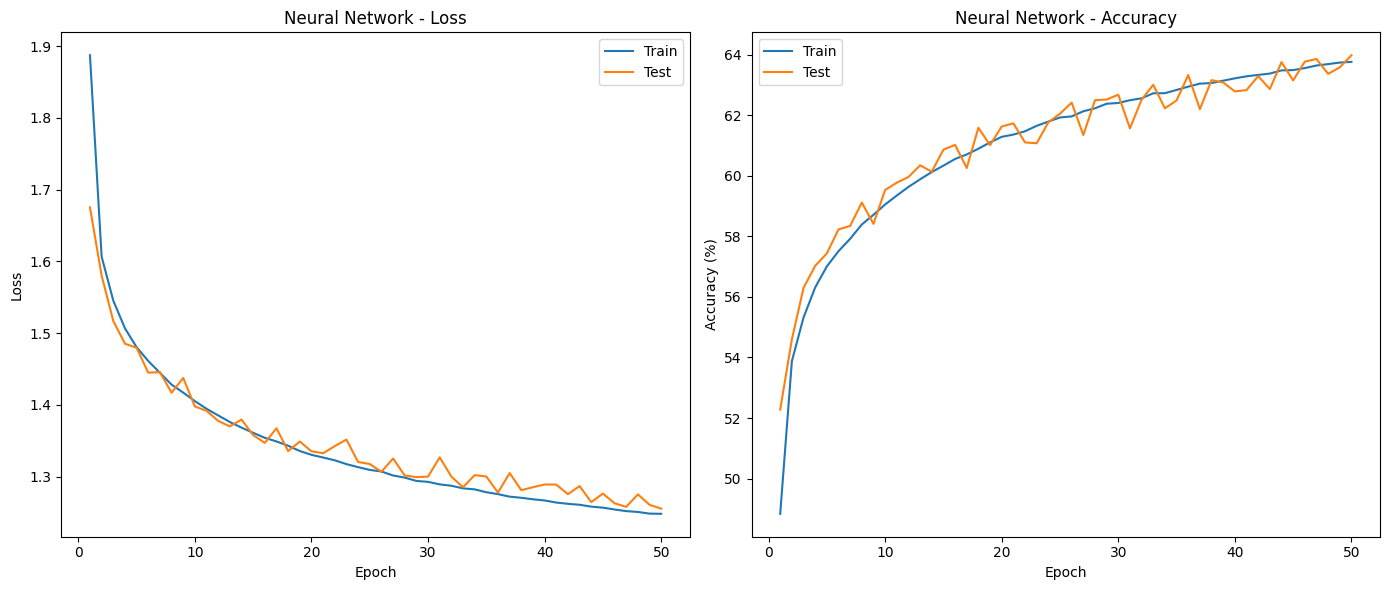

In [130]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

epochs = np.arange(1, len(train_accuracies) + 1)

# Plot Loss
ax1.plot(epochs, train_losses, label='Train')
ax1.plot(epochs, test_losses, label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Neural Network - Loss')
ax1.legend()

# Plot Accuracy
ax2.plot(epochs, train_accuracies, label='Train')
ax2.plot(epochs, test_accuracies, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Neural Network - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [153]:
# Check Errors
model.eval()
all_predictions = []
all_actuals = []

# Make predictions
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_actuals.extend(labels.numpy())

# Convert to np.arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Covert to DF
errors_df = pd.DataFrame({'actual': all_actuals, 'predicted': all_predictions})

# Find errors
errors_df = errors_df[errors_df['actual'] != errors_df['predicted']]

# Count most common confusions
confusion_counts = errors_df.groupby(['actual', 'predicted']).size().reset_index(name='count')
confusion_counts = confusion_counts.sort_values('count', ascending=False)


# Map topic names
topic_enc = pd.read_csv('data/processed/topic_enc.csv')

confusion_counts = confusion_counts.merge(
    topic_enc, 
    left_on='actual', 
    right_on='TOPIC_encoded',
    how='left'
).rename(columns={'TOPIC': 'Actual Topic'}).drop(columns=['TOPIC_encoded'])

confusion_counts = confusion_counts.merge(
    topic_enc, 
    left_on='predicted', 
    right_on='TOPIC_encoded',
    how='left'
).rename(columns={'TOPIC': 'Predicted Topic'}).drop(columns=['TOPIC_encoded'])




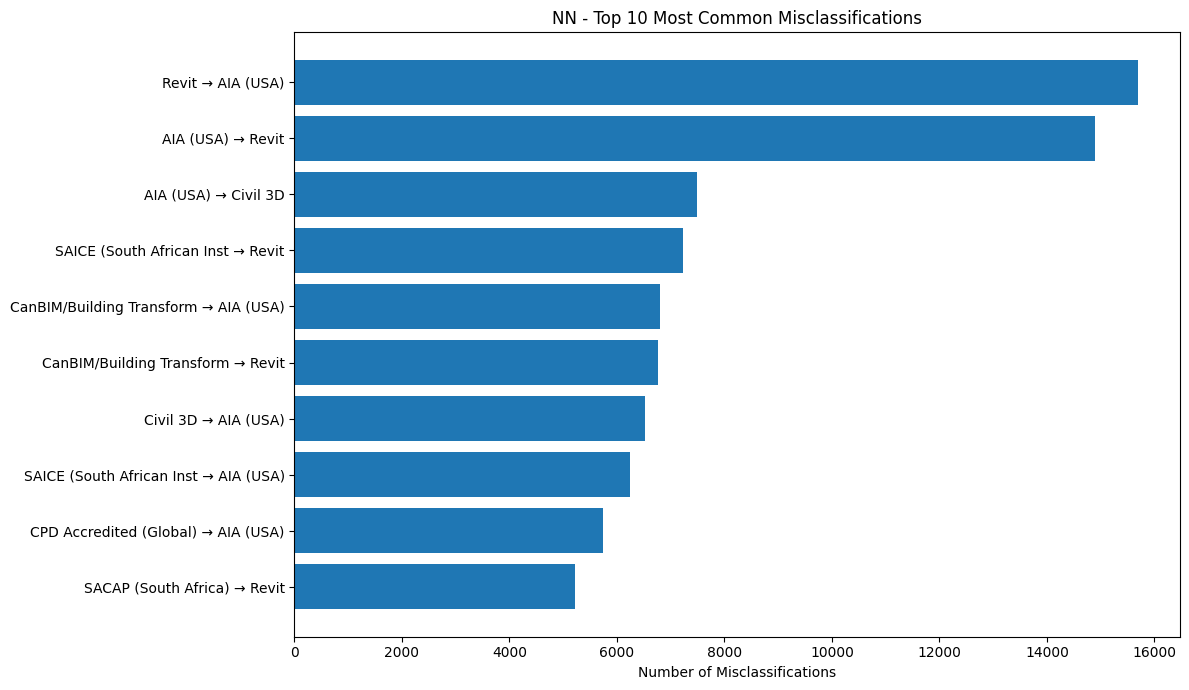

In [155]:
# Create visualization of top 10 confusions
top_10_confusions = confusion_counts.head(10).copy()

# Create shorter labels for readability
top_10_confusions['confusion_pair'] = (top_10_confusions['Actual Topic'].str[:25] + ' → ' + top_10_confusions['Predicted Topic'].str[:25])
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(top_10_confusions)), top_10_confusions['count'])
ax.set_yticks(range(len(top_10_confusions)))
ax.set_yticklabels(top_10_confusions['confusion_pair'])
ax.set_xlabel('Number of Misclassifications')
ax.set_title('NN - Top 10 Most Common Misclassifications')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


# Making Recommendations

Using both models, I will now make predictions on 10 validation users. A successful recommendation will be graded on if the recommended Topic matches the target Topic in the NN dataset. Both the KNN and NN model will make reocmmendations, KNN will provide top 3. 


In [ ]:
# Read in interactions data
neural_network_dataset_val = pd.read_csv('data/processed/neural_network_dataset_val.csv')
interactions_agg_long_val = pd.read_csv('data/processed/interactions_agg_long_val.csv')
knn_dataset_val = pd.read_csv('data/processed/knn_dataset_val.csv')

knn_validation_users = knn_dataset_val.copy()
nn_validation_users = neural_network_dataset_val.copy()

# Create an array of topic_subtopics
nn_validation_users['topic_subtopics'] = nn_validation_users.apply(
    lambda row: [
        row['topic_subtopic_1'],
        row['topic_subtopic_2'],
        row['topic_subtopic_3'],
        row['topic_subtopic_4'],
        row['topic_subtopic_5']
    ],
    axis=1
)

# Select and reorder columns
nn_validation_users = nn_validation_users[[
    'user_id',
    'topic_subtopics',
    'target_topic'
]]

#print(knn_validation_users.head(1))
#print(nn_validation_users.head(1))

In [145]:
# Load topic encoding
topic_enc = pd.read_csv('data/processed/topic_enc.csv')

# KNN Predictions - TOP 3
knn_predictions = []
for id, user in knn_validation_users.iterrows(): # Loop through rows/users
    # Get user features and scale
    user_features = user[train_cols].values.reshape(1, -1) # Extract topics user has consumed
    user_features_scaled = scaler.transform(user_features) # Standardize similar to above
    
    # Find neighbors and calculate scores
    distances, neighbor_indices = knn_model_final.kneighbors(user_features_scaled, n_neighbors=3) # Grab distances and row positions
    neighbors = train_knn.iloc[neighbor_indices[0]] # Only first row
    neighbor_consumption = neighbors[train_cols].values # Grab topic consumption from neighbors
    
    # Weighted scores
    similarities = 1 / (1 + distances[0]) # Similarity scores
    weights = similarities / similarities.sum() # Normalize to sum to 1
    scores = np.dot(weights, neighbor_consumption) # Calculate weighted average for each topic across all neighbors
    
    # Get top 3 predictions
    top_3_indices = np.argsort(scores)[::-1][:3] # Sort and grab top 3
    top_3_topics = [train_cols[id] for id in top_3_indices] # Grab topics from indexes
    
    # Prediction dictionary
    knn_predictions.append({
        'user_id': user['USER_ID'],
        'knn_prediction_1': top_3_topics[0],
        'knn_prediction_2': top_3_topics[1],
        'knn_prediction_3': top_3_topics[2]
    })

# Convert to DF
knn_df = pd.DataFrame(knn_predictions)



# NN Predictions
nn_predictions = []
model.eval() # Put nn model into evaluation mode
for id, user in nn_validation_users.iterrows(): # Loop through rows/users
    
    input_tensor = torch.FloatTensor(user['topic_subtopics']).unsqueeze(0).to(device) # Convert to float and ensure proper shape
    
    # Get prediction
    with torch.no_grad(): # Don't track gradients
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1) # Convert scores to probabilities
        top_prob, top_id = torch.max(probabilities, dim=1) # Grab top probability and topic
    
    # Get topic names
    predicted_topic_id = top_id.item() # Get number from PT Tensor
    predicted_topic_name = topic_enc[topic_enc['TOPIC_encoded'] == predicted_topic_id]['TOPIC'].values # Grab value from matching encoding
    actual_topic_name = topic_enc[topic_enc['TOPIC_encoded'] == user['target_topic']]['TOPIC'].values # Grab target value from matching encoding
    
    # Prediction dictionary
    nn_predictions.append({
        'user_id': user['user_id'],
        'target_topic': actual_topic_name,
        'nn_prediction': predicted_topic_name
    })

# Convert to DF
nn_df = pd.DataFrame(nn_predictions)



# Merge NN and KNN predictions
results = nn_df.merge(knn_df, on='user_id', how='left')

# Add accuracy columns
results['nn_correct'] = results['nn_prediction'] == results['target_topic'] # If NN pred = target then TRUE

# KNN is correct if target matches ANY of the top 3 predictions
results['knn_correct'] = (
    (results['knn_prediction_1'] == results['target_topic']) |
    (results['knn_prediction_2'] == results['target_topic']) |
    (results['knn_prediction_3'] == results['target_topic'])
) # If any KNN prediction equals target then TRUE

results['either_correct'] = results['nn_correct'] | results['knn_correct'] # If NN or KNN pred is accurate, then TRUE 

# Accuracies
nn_accuracy = results['nn_correct'].mean()
knn_accuracy = results['knn_correct'].mean()
combined_accuracy = results['either_correct'].mean()

print(f"NN Accuracy: {nn_accuracy:.1%}")
print(f"KNN- Accuracy: {knn_accuracy:.1%}")
print(f"Combined Accuracy: {combined_accuracy:.1%}")

results.to_csv('data/processed/model_comparison_results.csv', index=False)

NN Accuracy: 57.8%
KNN- Accuracy: 59.9%
Combined Accuracy: 81.5%


Using both the KNN and NN models, we can provide a recommendation with 82% confidence that it is something the user will find relevant to them. 

In [171]:
# Performance by Industry and Segment

# Merge validation results with industry/segment data
validation_with_metadata = results.merge(
    knn_validation_users[['USER_ID', 'INDUSTRY', 'SEGMENT']], 
    left_on='user_id', 
    right_on='USER_ID',
    how='left'
)

# Calculate accuracy by industry
industry_performance = validation_with_metadata.groupby('INDUSTRY').agg({'nn_correct': 'mean', 'knn_correct': 'mean', 'either_correct': 'mean'}).round(3) * 100  # Convert to percentage

# Calculate accuracy by segment
segment_performance = validation_with_metadata.groupby('SEGMENT').agg({'nn_correct': 'mean', 'knn_correct': 'mean', 'either_correct': 'mean'}).round(3) * 100  # Convert to percentage


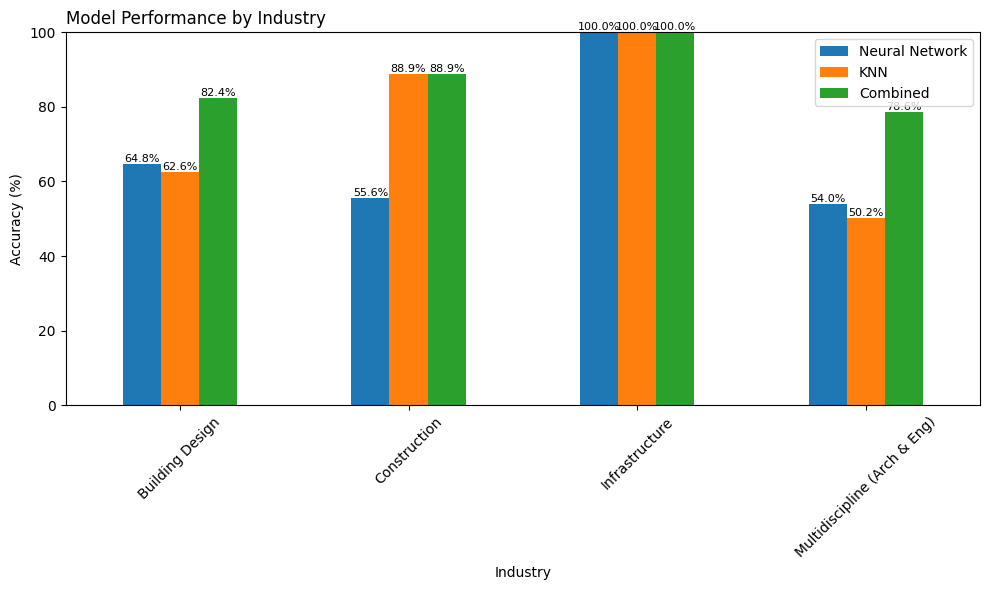

In [172]:
# Industry Performance Chart
fig, ax = plt.subplots(figsize=(10, 6))

industry_performance.plot(kind='bar', ax=ax)
ax.set_xlabel('Industry')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Performance by Industry', loc='left')
ax.set_ylim(0, 100)
ax.legend(['Neural Network', 'KNN', 'Combined'])
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.show()

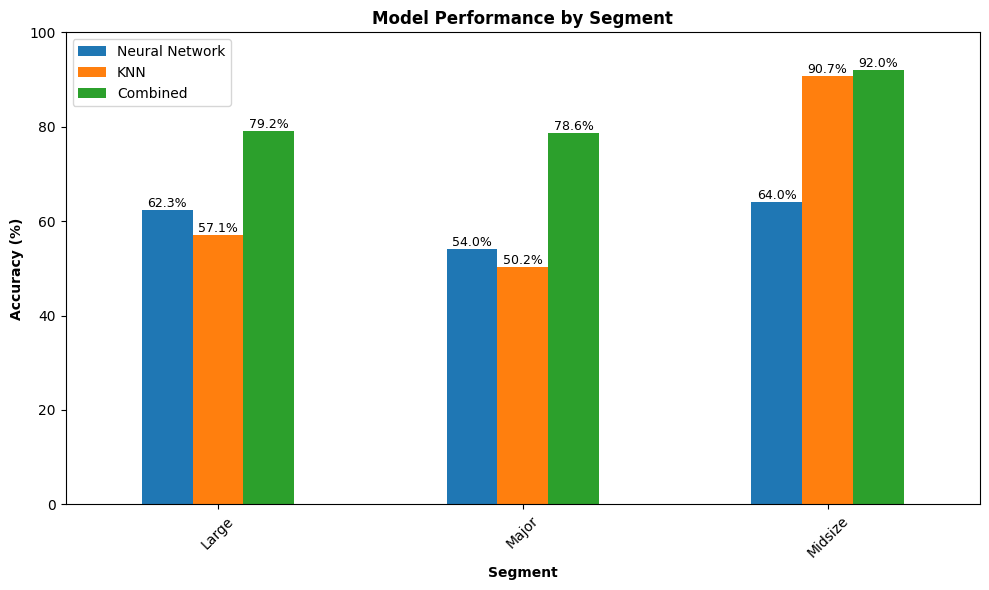

In [169]:
# Segment Performance Chart
fig, ax = plt.subplots(figsize=(10, 6))

segment_performance.plot(kind='bar', ax=ax)
ax.set_xlabel('Segment', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Model Performance by Segment', fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(['Neural Network', 'KNN', 'Combined'])
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.tight_layout()
plt.show()